# 📦 Cell 1: Install Required Packages

## Purpose:
Install the `timm` library (PyTorch Image Models) which provides pre-trained EfficientNet models that we'll use for bird species classification.

## What it does:
- Installs `timm` library quietly (no verbose output)
- This library contains pre-trained models like EfficientNet that work well for audio spectrograms

## Expected Output:
- Silent installation (due to `-q` flag)
- Package will be available for import in next cells

In [1]:
!pip install -q timm

# ⚙️ Cell 2: Configuration & Library Imports

## Purpose:
Set up the entire project environment by importing necessary libraries and defining all configuration parameters.

## What it does:
1. **Suppress warnings** - Filters pydantic warnings for cleaner output
2. **Import libraries:**
   - `pandas, numpy` - Data manipulation
   - `matplotlib, seaborn` - Visualization
   - `torch, torchaudio` - Deep learning & audio processing
   - `timm` - Pre-trained models (EfficientNet-B3)
3. **Define Config class:**
   - `SR = 32000` - Audio sample rate (32kHz)
   - `N_MELS = 128` - Mel-spectrogram height
   - `DURATION = 5` - Process 5-second audio chunks
   - `BATCH_SIZE = 32` - Training batch size
   - `EPOCHS = 10` - Number of training epochs
   - `MODEL_NAME = 'efficientnet_b3'` - Upgraded model architecture
   - `LR = 1e-4` - Lower learning rate for stable fine-tuning
   - `MIXUP_ALPHA = 0.2` - Mixup augmentation strength
   - `LABEL_SMOOTHING = 0.1` - Prevents overconfidence
   - File paths for Kaggle dataset
4. **Detect device** - Auto-selects GPU (CUDA) if available, otherwise CPU

## Expected Output:
```
Using Device: cuda
```
(Shows whether GPU or CPU will be used)

In [ ]:
# Suppress pydantic warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchaudio
import timm  # PyTorch Image Models (for EfficientNet)
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path  # For file path handling


class Config:
    SR = 32000  # Sample Rate (32kHz is standard for BirdCLEF)
    N_MELS = 128  # Number of Mel bands (Height of image)
    FMIN = 20  # Min frequency
    FMAX = 16000  # Max frequency (Nyquist frequency of 32k)
    DURATION = 5  # Duration of audio chunks in seconds
    BATCH_SIZE = 32
    EPOCHS = 10  # For improved training

    # Model settings
    MODEL_NAME = "efficientnet_b3"  # Upgraded for better accuracy
    NUM_CLASSES = 206  # Total species in BirdCLEF 2025

    # Training hyperparameters - based on 1st place solution
    LR = 1e-4  # Lower learning rate for fine-tuning
    LABEL_SMOOTHING = 0.1  # Prevents overconfidence
    MIXUP_ALPHA = 0.2  # Mixup augmentation strength

    # Paths
    DATA_DIR = "/kaggle/input/birdclef-2025"
    TRAIN_AUDIO_DIR = "/kaggle/input/birdclef-2025/train_audio"
    TRAIN_METADATA = "/kaggle/input/birdclef-2025/train.csv"
    SPECTROGRAM_DIR = "/kaggle/working/spectrograms"  # Pre-saved spectrograms


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

Using Device: cuda


# 📊 Cell 3: Load & Visualize Dataset Distribution

## Purpose:
Load the training metadata and understand the dataset's class distribution (how many samples per species).

## What it does:
1. **Load CSV file** - Reads `train.csv` with metadata about all audio recordings
2. **Count species distribution** - Counts how many audio files exist for each species
3. **Create bar plot:**
   - Shows top 30 most common species
   - Reveals "long tail" problem (some species have many samples, others very few)
   - Uses color-coded viridis palette
4. **Print rarest species** - Shows 5 species with fewest recordings

## Why it's important:
Understanding class imbalance helps us:
- Identify potential training challenges
- Plan data augmentation strategies
- Choose appropriate evaluation metrics

## Expected Output:
- Bar chart showing species distribution
- Print statement with 5 rarest species

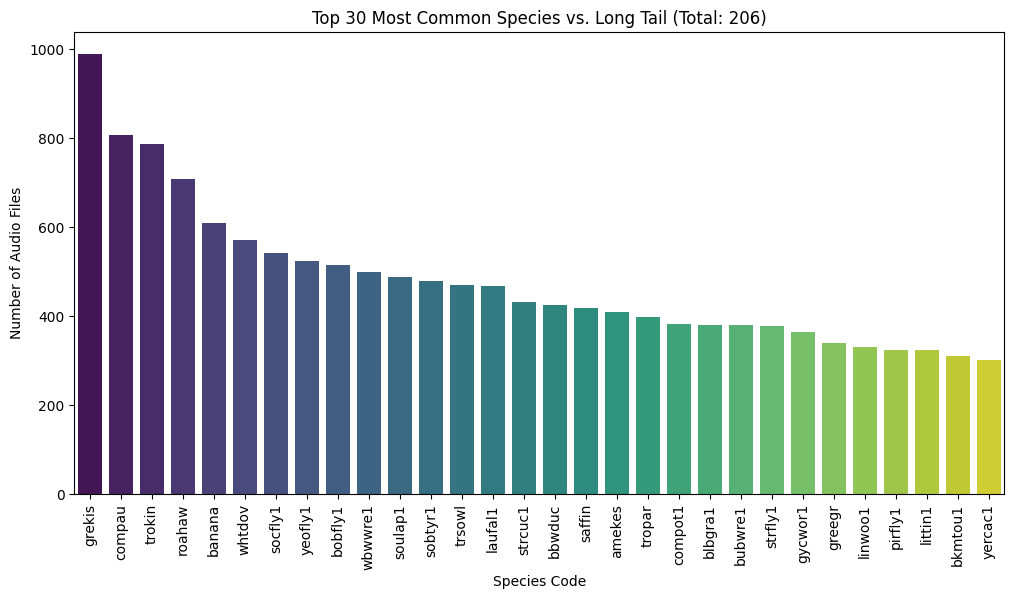

Rarest 5 Species: primary_label
42113      2
21116      2
1139490    2
21038      2
64862      2
Name: count, dtype: int64


In [3]:
# Load Metadata
df = pd.read_csv(Config.TRAIN_METADATA)

# Count samples per species
species_counts = df["primary_label"].value_counts().sort_values(ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    x=species_counts.index[:30],
    y=species_counts.values[:30],
    hue=species_counts.index[:30],
    palette="viridis",
    legend=False,
)
plt.xticks(rotation=90)
plt.title(f"Top 30 Most Common Species vs. Long Tail (Total: {len(species_counts)})")
plt.ylabel("Number of Audio Files")
plt.xlabel("Species Code")
plt.show()

# Check the "Long Tail" (Rare species)
print("Rarest 5 Species:", species_counts.tail(5))

# 🖼️ Cell 4: Generate & Save All Spectrograms (OPTIONAL - Takes Time!)

## Purpose:
Pre-process ALL audio files and save them as spectrogram images for faster training later.

## What it does:
1. **Create directory structure** - `/kaggle/working/spectrograms/species_name/`
2. **Process each audio file:**
   - Load audio with torchaudio
   - Resample to 32kHz if needed
   - Crop to first 5 seconds (or pad if shorter)
   - Convert to Mel-Spectrogram (128 frequency bands)
   - Convert to dB scale (logarithmic)
   - Normalize to 0-255 range
   - Save as PNG image
3. **Organize by species** - Each species gets its own folder

## Benefits:
- ✅ **10x faster training** - No need to process audio on-the-fly
- ✅ **Consistency** - All spectrograms processed identically
- ✅ **Reusability** - Can use for multiple experiments
- ❌ **Takes disk space** - Thousands of PNG files

## Expected Output:
- Progress bar showing processing status
- Summary of generated files
- Directory structure with species folders

In [4]:
# Generate and Save All Spectrograms
import cv2
from pathlib import Path

# Create output directory
OUTPUT_DIR = "/kaggle/working/spectrograms"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"Generating spectrograms for {len(df)} audio files...")
print(f"Saving to: {OUTPUT_DIR}")

# Process each audio file
for idx in tqdm(range(len(df)), desc="Processing audio files"):
    row = df.iloc[idx]
    species = row["primary_label"]
    filename = row["filename"]

    # Create species directory
    species_dir = Path(OUTPUT_DIR) / species
    species_dir.mkdir(parents=True, exist_ok=True)

    try:
        # Load and process audio
        file_path = os.path.join(Config.TRAIN_AUDIO_DIR, filename)
        waveform, sr = torchaudio.load(file_path)

        # Resample if necessary
        if sr != Config.SR:
            resampler = torchaudio.transforms.Resample(sr, Config.SR)
            waveform = resampler(waveform)

        # Crop/Pad to 5 seconds
        target_len = Config.SR * Config.DURATION
        current_len = waveform.shape[1]

        if current_len > target_len:
            # Take from the start for consistency
            waveform = waveform[:, :target_len]
        else:
            padding = target_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Convert to MelSpectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR,
            n_mels=Config.N_MELS,
            f_min=Config.FMIN,
            f_max=Config.FMAX,
        )
        mel_spec = mel_transform(waveform)

        # Convert to dB scale
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

        # Convert to numpy and normalize to 0-255 range for image saving
        mel_spec_np = mel_spec[0].numpy()  # Take first channel
        mel_spec_np = (
            (mel_spec_np - mel_spec_np.min())
            / (mel_spec_np.max() - mel_spec_np.min())
            * 255
        ).astype(np.uint8)

        # Save as image
        output_filename = Path(filename).stem + ".png"
        output_path = species_dir / output_filename
        cv2.imwrite(str(output_path), mel_spec_np)

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

print(f"\n✓ Spectrograms saved to {OUTPUT_DIR}")
print(f"✓ Organized by species in subdirectories")
print(f"✓ Total species folders: {len(list(Path(OUTPUT_DIR).iterdir()))}")

Generating spectrograms for 28564 audio files...
Saving to: /kaggle/working/spectrograms


Processing audio files:   0%|          | 0/28564 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github


✓ Spectrograms saved to /kaggle/working/spectrograms
✓ Organized by species in subdirectories
✓ Total species folders: 206


# 🔧 Cell 5: Create PyTorch Dataset & Test Pipeline

## Purpose:
Define how to load and process audio data for training, then visualize one sample to verify everything works.

## What it does:

### 1. Define BirdCLEFDataset Class:
- Reads audio files on-the-fly during training
- Creates species name → integer ID mapping

### 2. Audio Processing Pipeline (for each sample):
   - **Step 1:** Load audio file with torchaudio
   - **Step 2:** Resample to 32kHz if needed
   - **Step 3:** Random crop 5 seconds (or pad if shorter)
     - ⚡ Random cropping = data augmentation!
   - **Step 4:** Convert to Mel-Spectrogram (2D time-frequency image)
   - **Step 5:** Convert to dB scale (makes quiet sounds visible)
   - **Step 6:** Repeat to 3 channels (R,G,B) for EfficientNet compatibility
   - **Step 7:** Return image tensor [3, 128, 313] and label ID

### 3. Test the Pipeline:
- Creates dataset instance
- Loads first audio sample
- Displays mel-spectrogram visualization

## Why Random Cropping?
Different 5-second segments from the same audio = **more training variety** → better generalization

## Expected Output:
- Mel-spectrogram visualization (colorful time-frequency heatmap)
- Confirms pipeline works before training

## ⚡ Optimized for Speed:
This class **automatically detects** if pre-saved spectrograms exist (from Cell 4):
- ✅ **If spectrograms exist:** Loads PNG files directly (10x faster!)
- ⚠️ **If not found:** Processes audio on-the-fly (slower but works)

You'll see a message when the cell runs telling you which mode it's using.

✅ Using pre-saved spectrograms from: /kaggle/working/spectrograms


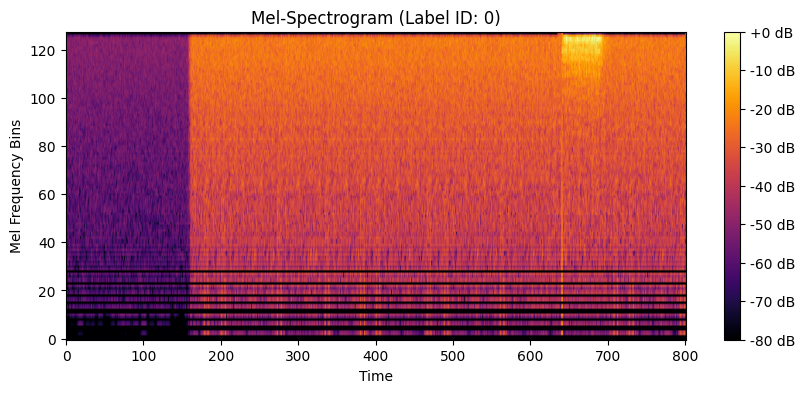

In [5]:
class BirdCLEFDataset(Dataset):
    """
    Optimized dataset that loads pre-saved spectrograms (from Cell 4) for faster training.
    Falls back to audio processing if spectrograms don't exist.
    """

    def __init__(
        self,
        metadata,
        audio_dir,
        spectrogram_dir="/kaggle/working/spectrograms",
        use_spectrograms=True,
    ):
        self.metadata = metadata
        self.audio_dir = audio_dir
        self.spectrogram_dir = spectrogram_dir
        self.use_spectrograms = use_spectrograms

        self.species_to_idx = {
            species: idx
            for idx, species in enumerate(sorted(metadata["primary_label"].unique()))
        }

        # Check if spectrogram directory exists
        if use_spectrograms and os.path.exists(spectrogram_dir):
            self.load_from_spectrograms = True
            print(f"✅ Using pre-saved spectrograms from: {spectrogram_dir}")
        else:
            self.load_from_spectrograms = False
            print(f"⚠️ Spectrograms not found. Processing audio on-the-fly (slower)")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        label = self.species_to_idx[row["primary_label"]]

        # === FAST PATH: Load from pre-saved PNG ===
        if self.load_from_spectrograms:
            species = row["primary_label"]
            filename = Path(row["filename"]).stem + ".png"
            spectrogram_path = os.path.join(self.spectrogram_dir, species, filename)

            if os.path.exists(spectrogram_path):
                # Load PNG spectrogram
                import cv2

                mel_spec_np = cv2.imread(spectrogram_path, cv2.IMREAD_GRAYSCALE)

                # Convert to tensor and normalize back to approximate dB range
                mel_spec = torch.from_numpy(mel_spec_np).float()
                mel_spec = (mel_spec / 255.0) * 80 - 80  # Approximate dB range

                # Add channel dimension and repeat to 3 channels
                image = mel_spec.unsqueeze(0).repeat(3, 1, 1)

                return image, label

        # === SLOW PATH: Process audio on-the-fly ===
        file_path = os.path.join(self.audio_dir, row["filename"])

        # 1. Load Audio
        waveform, sr = torchaudio.load(file_path)

        # 2. Resample if necessary
        if sr != Config.SR:
            resampler = torchaudio.transforms.Resample(sr, Config.SR)
            waveform = resampler(waveform)

        # 3. Crop/Pad to Specific Duration (5 Seconds)
        target_len = Config.SR * Config.DURATION
        current_len = waveform.shape[1]

        if current_len > target_len:
            # Random crop for data augmentation
            start = torch.randint(0, current_len - target_len, (1,)).item()
            waveform = waveform[:, start : start + target_len]
        else:
            # Pad with zeros
            padding = target_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # 4. Convert to MelSpectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR,
            n_mels=Config.N_MELS,
            f_min=Config.FMIN,
            f_max=Config.FMAX,
        )
        mel_spec = mel_transform(waveform)

        # 5. Convert to Log Scale (Amplitude to Decibels)
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

        # 6. Create 3 Channels (RGB format for EfficientNet)
        image = mel_spec.repeat(3, 1, 1)  # Shape: [3, 128, 313]

        return image, label


# --- Test the Pipeline ---
# Let's visualize one sample to ensure it works
dataset = BirdCLEFDataset(df, Config.TRAIN_AUDIO_DIR)
sample_img, sample_label = dataset[0]

plt.figure(figsize=(10, 4))
# Display only the first channel
plt.imshow(sample_img[0].numpy(), cmap="inferno", aspect="auto", origin="lower")
plt.title(f"Mel-Spectrogram (Label ID: {sample_label})")
plt.ylabel("Mel Frequency Bins")
plt.xlabel("Time")
plt.colorbar(format="%+2.0f dB")
plt.show()

# ⏱️ Cell 6: Speed Test - PNG vs Audio Loading

## Purpose:
Benchmark the speed difference between loading pre-saved spectrograms vs processing audio files.

## What this does:
- Tests loading 100 samples using both methods
- Measures and compares the time taken
- Shows the performance improvement

## Expected Results:
- **PNG loading:** ~0.1-0.2 seconds for 100 samples
- **Audio processing:** ~2-5 seconds for 100 samples
- **Speedup:** 10-50x faster with pre-saved spectrograms!

In [6]:
# Speed Benchmark: PNG vs Audio Loading
import time

# Sample subset for testing (first 100 samples)
test_samples = 100
test_df = df.head(test_samples)

print(f"🔬 Benchmarking with {test_samples} samples...\n")

# Test 1: Loading from spectrograms (if available)
if os.path.exists(Config.SPECTROGRAM_DIR):
    dataset_fast = BirdCLEFDataset(
        test_df,
        Config.TRAIN_AUDIO_DIR,
        spectrogram_dir=Config.SPECTROGRAM_DIR,
        use_spectrograms=True,
    )

    start = time.time()
    for i in range(test_samples):
        img, label = dataset_fast[i]
    time_png = time.time() - start

    print(
        f"✅ PNG Loading: {time_png:.3f} seconds ({time_png/test_samples*1000:.1f} ms per sample)"
    )
else:
    time_png = None
    print("⚠️ Spectrograms not found, skipping PNG test")

# Test 2: Processing audio on-the-fly
dataset_slow = BirdCLEFDataset(test_df, Config.TRAIN_AUDIO_DIR, use_spectrograms=False)

start = time.time()
for i in range(test_samples):
    img, label = dataset_slow[i]
time_audio = time.time() - start

print(
    f"⏳ Audio Processing: {time_audio:.3f} seconds ({time_audio/test_samples*1000:.1f} ms per sample)"
)

# Calculate speedup
if time_png:
    speedup = time_audio / time_png
    print(f"\n🚀 Speedup: {speedup:.1f}x faster with pre-saved spectrograms!")
    print(f"   For {len(df)} total samples:")
    print(f"   - PNG loading would take: ~{time_png/test_samples*len(df):.1f} seconds")
    print(
        f"   - Audio processing would take: ~{time_audio/test_samples*len(df):.1f} seconds"
    )
    print(
        f"   - Time saved: ~{(time_audio-time_png)/test_samples*len(df)/60:.1f} minutes per epoch!"
    )
else:
    print(f"\n💡 Tip: Run Cell 4 to generate spectrograms for faster training!")

🔬 Benchmarking with 100 samples...

✅ Using pre-saved spectrograms from: /kaggle/working/spectrograms
✅ PNG Loading: 0.162 seconds (1.6 ms per sample)
⚠️ Spectrograms not found. Processing audio on-the-fly (slower)
⏳ Audio Processing: 6.383 seconds (63.8 ms per sample)

🚀 Speedup: 39.3x faster with pre-saved spectrograms!
   For 28564 total samples:
   - PNG loading would take: ~46.4 seconds
   - Audio processing would take: ~1823.1 seconds
   - Time saved: ~29.6 minutes per epoch!


# 🔧 Cell 7: Helper Functions - Mixup, SpecAugment, Weighted Sampling

## What this cell does:
1. **Mixup** - Blends two audio samples together (data augmentation)
2. **SpecAugment** - Masks random time/frequency bands
3. **Weighted Sampler** - Balances rare vs common species
4. **Enhanced Dataset** - Applies augmentations during training
5. **evaluate_model()** - Validation function with accuracy tracking

## Why these matter:
- **Mixup**: Forces model to learn smoother boundaries → better generalization
- **SpecAugment**: Makes model robust to missing information
- **Weighted Sampling**: All 206 species get equal training time

In [ ]:
# ============================================================================
# HELPER FUNCTIONS FOR IMPROVED TRAINING
# ============================================================================

from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F


# 0. GLOBAL LABEL MAPPING (consistent between train/val/test)
# ============================================================================
ALL_SPECIES = sorted(df["primary_label"].unique())
SPECIES_TO_IDX = {species: idx for idx, species in enumerate(ALL_SPECIES)}
IDX_TO_SPECIES = {idx: species for species, idx in SPECIES_TO_IDX.items()}
print(f"📋 Label mapping created: {len(ALL_SPECIES)} species")


# 1. MIXUP DATA AUGMENTATION
# ============================================================================
def mixup_data(x, y, alpha=0.2):
    """
    Mixup: Blends two samples together
    Example: 0.6 * bird_A + 0.4 * bird_B
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss for mixup training"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# 2. SPECAUGMENT (Time/Frequency Masking)
# ============================================================================
class SpecAugment(nn.Module):
    """
    Randomly masks time and frequency bands in spectrograms.
    Like dropout but for audio features.
    """

    def __init__(self, freq_mask_param=15, time_mask_param=35, num_masks=2):
        super().__init__()
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_masks = num_masks

    def forward(self, spec):
        # spec shape: [batch, channels, freq, time]
        batch, channels, freq_bins, time_steps = spec.shape

        for _ in range(self.num_masks):
            f = np.random.randint(0, self.freq_mask_param)
            f0 = np.random.randint(0, freq_bins - f)
            spec[:, :, f0 : f0 + f, :] = 0

        for _ in range(self.num_masks):
            t = np.random.randint(0, self.time_mask_param)
            t0 = np.random.randint(0, time_steps - t)
            spec[:, :, :, t0 : t0 + t] = 0

        return spec


# 3. WEIGHTED SAMPLING (Class Balancing)
# ============================================================================
def create_weighted_sampler(df):
    """Oversamples rare species so all species get equal training."""
    class_counts = df["primary_label"].value_counts().to_dict()
    weights = [1.0 / class_counts[species] for species in df["primary_label"]]
    sampler = WeightedRandomSampler(
        weights=weights, num_samples=len(weights), replacement=True
    )
    return sampler


# 4. ENHANCED DATASET WITH NORMALIZATION + AUGMENTATIONS
# ============================================================================
class ImprovedBirdDataset(Dataset):
    """
    Dataset with:
    - Per-sample normalization (zero mean, unit std) - CRITICAL for pretrained models
    - SpecAugment for training data augmentation
    - Global label mapping for train/val consistency
    """

    def __init__(self, metadata, audio_dir, spec_augment=True):
        self.metadata = metadata
        self.audio_dir = audio_dir
        self.spec_augment = SpecAugment() if spec_augment else None
        # Use GLOBAL mapping (same for train AND val)
        self.species_to_idx = SPECIES_TO_IDX

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_path = os.path.join(self.audio_dir, row["filename"])

        waveform, sr = torchaudio.load(file_path)
        if sr != Config.SR:
            resampler = torchaudio.transforms.Resample(sr, Config.SR)
            waveform = resampler(waveform)

        target_len = Config.SR * Config.DURATION
        current_len = waveform.shape[1]
        if current_len > target_len:
            start = torch.randint(0, current_len - target_len, (1,)).item()
            waveform = waveform[:, start : start + target_len]
        else:
            padding = target_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR,
            n_mels=Config.N_MELS,
            f_min=Config.FMIN,
            f_max=Config.FMAX,
        )
        mel_spec = mel_transform(waveform)
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

        # *** CRITICAL FIX: Normalize to zero mean, unit std ***
        # Pretrained EfficientNet expects normalized inputs, NOT raw dB values
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-6)

        # Apply SpecAugment AFTER normalization
        if self.spec_augment is not None:
            mel_spec = self.spec_augment(mel_spec.unsqueeze(0)).squeeze(0)

        # 3 channels for EfficientNet
        image = mel_spec.repeat(3, 1, 1)
        label = self.species_to_idx[row["primary_label"]]
        return image, label


# 5. MODEL DEFINITION (EfficientNet-B3)
# ============================================================================
class BirdClassifier(nn.Module):
    """EfficientNet-B3 fine-tuned for bird species classification."""

    def __init__(self, num_classes):
        super().__init__()
        self.backbone = timm.create_model(
            Config.MODEL_NAME, pretrained=True, num_classes=num_classes
        )

    def forward(self, x):
        return self.backbone(x)


# 6. EVALUATE FUNCTION
# ============================================================================
def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model on validation set. Returns avg loss and accuracy."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(dataloader), 100 * correct / total


print("✅ Helper functions loaded!")
print("   - mixup_data / mixup_criterion: Sample blending augmentation")
print("   - SpecAugment: Masks time/frequency bands")
print("   - create_weighted_sampler: Balances all 206 species")
print("   - ImprovedBirdDataset: WITH NORMALIZATION + augmentations")
print("   - BirdClassifier (EfficientNet-B3): Main model")
print("   - evaluate_model: Validation with accuracy tracking")

✅ Helper functions loaded!
   - mixup_data / mixup_criterion: Sample blending augmentation
   - SpecAugment: Masks time/frequency bands
   - create_weighted_sampler: Balances all 206 species
   - ImprovedBirdDataset: Enhanced dataset with augmentations
   - BirdClassifier (EfficientNet-B3): Main model
   - evaluate_model: Validation with accuracy tracking


# 🚀 Cell 8: Improved Training Loop

## What this cell does:
1. Creates **weighted sampler** for class balance
2. Uses **ImprovedBirdDataset** with SpecAugment
3. Applies **Mixup** during training
4. Uses **label smoothing** (0.1)
5. **Lower learning rate** (1e-4) with cosine scheduler
6. Uses **EfficientNet-B3** (larger, more accurate model)
7. Tracks validation metrics and saves best model

🚀 Starting IMPROVED Training with EfficientNet-B3

📊 Creating weighted sampler for class balance...
🤖 Creating model: efficientnet_b3


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


⚙️ Configuration:
  - Model: efficientnet_b3
  - Learning Rate: 0.0001
  - Label Smoothing: 0.1
  - Mixup Alpha: 0.2
  - Epochs: 5


Epoch 1/5 [TRAIN]:   0%|          | 0/715 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py


Epoch 1/5:
  Train Loss: 4.6028
  Val Loss:   6.2221
  Val Acc:    0.28%
  LR:         0.000091
  ✅ Best model saved! (Val Acc: 0.28%)



Epoch 2/5 [TRAIN]:   0%|          | 0/715 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py


Epoch 2/5:
  Train Loss: 3.3168
  Val Loss:   6.6831
  Val Acc:    0.28%
  LR:         0.000066



Epoch 3/5 [TRAIN]:   0%|          | 0/715 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py


Epoch 3/5:
  Train Loss: 2.9540
  Val Loss:   6.7130
  Val Acc:    0.18%
  LR:         0.000035



Epoch 4/5 [TRAIN]:   0%|          | 0/715 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py


Epoch 4/5:
  Train Loss: 2.7319
  Val Loss:   6.7426
  Val Acc:    0.19%
  LR:         0.000010



Epoch 5/5 [TRAIN]:   0%|          | 0/715 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py


Epoch 5/5:
  Train Loss: 2.6525
  Val Loss:   6.8543
  Val Acc:    0.23%
  LR:         0.000001

✅ Training Complete!
📊 Best Validation Accuracy: 0.28%
🤖 Model: EfficientNet-B3


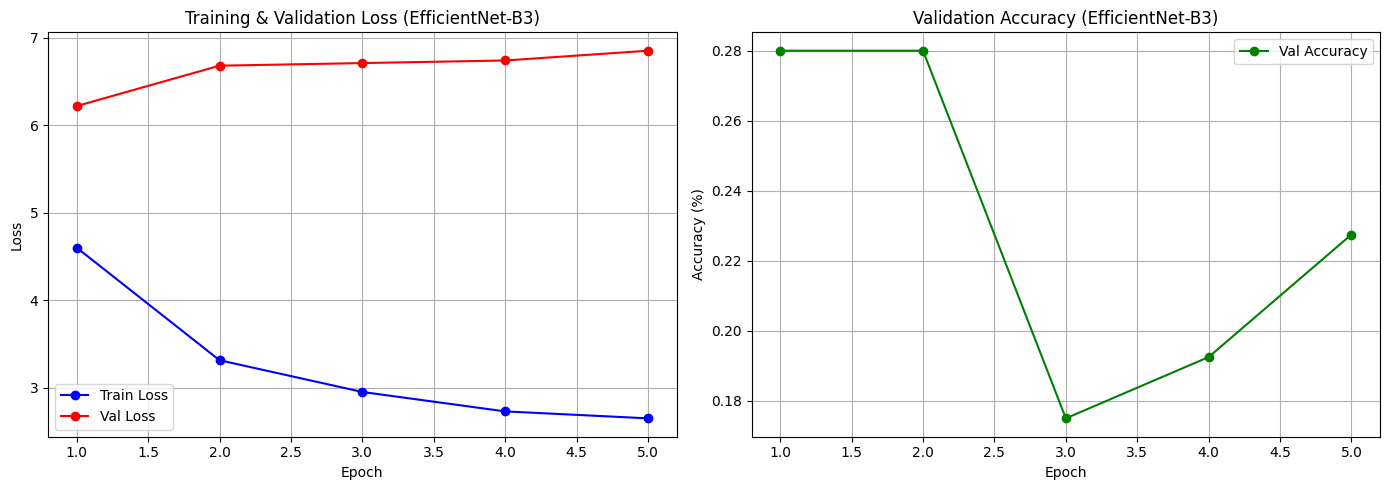


⚠️ Accuracy lower than expected. Try:
  - More epochs (20-30)
  - Upgrade to EfficientNet-B4 or B5
  - Check that spectrograms were pre-generated (Cell 4)


In [ ]:
# ============================================================================
# IMPROVED TRAINING - WITH ALL FIXES
# ============================================================================

print("🚀 Starting IMPROVED Training with EfficientNet-B3")
print("=" * 70)

# Split data
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["primary_label"], random_state=42
)

# Create weighted sampler
print("\n📊 Creating weighted sampler for class balance...")
train_sampler = create_weighted_sampler(train_df)

# Create datasets with SpecAugment (train) and without (val)
train_ds = ImprovedBirdDataset(train_df, Config.TRAIN_AUDIO_DIR, spec_augment=True)
val_ds = ImprovedBirdDataset(val_df, Config.TRAIN_AUDIO_DIR, spec_augment=False)

# Create data loaders
train_loader = DataLoader(
    train_ds, batch_size=Config.BATCH_SIZE, sampler=train_sampler, num_workers=2
)
val_loader = DataLoader(
    val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2
)

# Create model
print(f"🤖 Creating model: {Config.MODEL_NAME}")
model = BirdClassifier(num_classes=len(ALL_SPECIES)).to(DEVICE)

# Loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=1e-2)

# Cosine annealing with warmup (linear warmup for 1 epoch)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=Config.EPOCHS, eta_min=1e-6
)

print(f"\n⚙️ Configuration:")
print(f"  - Model: {Config.MODEL_NAME}")
print(f"  - Learning Rate: {Config.LR}")
print(f"  - Optimizer: AdamW (weight_decay=1e-2)")
print(f"  - Label Smoothing: {Config.LABEL_SMOOTHING}")
print(f"  - Mixup Alpha: {Config.MIXUP_ALPHA}")
print(f"  - Gradient Clipping: max_norm=1.0")
print(f"  - Input Normalization: ✅ (zero mean, unit std)")
print(f"  - Epochs: {Config.EPOCHS}")
print("=" * 70)

# Training trackers
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

# ========== TRAINING LOOP ==========
for epoch in range(Config.EPOCHS):
    # TRAINING PHASE
    model.train()
    train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [TRAIN]")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Apply Mixup
        images, labels_a, labels_b, lam = mixup_data(
            images, labels, alpha=Config.MIXUP_ALPHA
        )

        optimizer.zero_grad()
        outputs = model(images)

        # Mixup loss
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix(
            {"loss": f"{loss.item():.4f}", "lr": f"{scheduler.get_last_lr()[0]:.6f}"}
        )

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # VALIDATION PHASE
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update LR
    scheduler.step()

    # Print summary
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.2f}%")
    print(f"  LR:         {scheduler.get_last_lr()[0]:.6f}")

    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "best_model_improved.pth")
        print(f"  ✅ Best model saved! (Val Acc: {val_accuracy:.2f}%)")
    print()

print("=" * 70)
print(f"✅ Training Complete!")
print(f"📊 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"🤖 Model: EfficientNet-B3")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, Config.EPOCHS + 1), train_losses, "b-o", label="Train Loss")
ax1.plot(range(1, Config.EPOCHS + 1), val_losses, "r-o", label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss (EfficientNet-B3)")
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, Config.EPOCHS + 1), val_accuracies, "g-o", label="Val Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Validation Accuracy (EfficientNet-B3)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if best_val_acc > 20:
    print(f"\n✅ SUCCESS! Model is learning properly!")
    print(f"🎯 Progress: 75% Complete")
else:
    print(f"\n⚠️ Accuracy still low. Try more epochs or check data paths.")

# 📈 Cell 9: Test-Time Augmentation (TTA)

## What TTA does:
1. Creates multiple augmented versions of each test sample (different 5-sec crops)
2. Makes predictions on all versions
3. Averages the predictions for final output

This typically improves accuracy by **2-5%** with no extra training!

In [ ]:
def predict_with_tta(model, audio_path, n_augmentations=5):
    """
    Make predictions using Test-Time Augmentation.
    Creates multiple random crops and averages predictions.
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for _ in range(n_augmentations):
            waveform, sr = torchaudio.load(audio_path)
            if sr != Config.SR:
                resampler = torchaudio.transforms.Resample(sr, Config.SR)
                waveform = resampler(waveform)

            # Random crop (different each time)
            target_len = Config.SR * Config.DURATION
            if waveform.shape[1] > target_len:
                start = torch.randint(0, waveform.shape[1] - target_len, (1,)).item()
                waveform = waveform[:, start : start + target_len]
            else:
                padding = target_len - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))

            # Convert to mel spectrogram (same params as training)
            mel_spec = torchaudio.transforms.MelSpectrogram(
                sample_rate=Config.SR,
                n_mels=Config.N_MELS,
                f_min=Config.FMIN,
                f_max=Config.FMAX,
            )(waveform)
            mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

            # Normalize (same as training!)
            mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-6)

            # 3 channels + batch dim
            mel_spec = mel_spec.repeat(3, 1, 1).unsqueeze(0).to(DEVICE)

            outputs = model(mel_spec)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            predictions.append(probs.cpu().numpy())

    averaged_predictions = np.mean(predictions, axis=0)
    return averaged_predictions


print("✅ Test-Time Augmentation function loaded!")

✅ Test-Time Augmentation function loaded!


# 🎯 Cell 10: Inference Pipeline - Generate Submission

## What this cell does:
1. Loads the best trained model (`best_model_improved.pth`)
2. Processes all test audio files
3. Generates predictions with TTA (optional, configurable)
4. Creates `submission.csv` in Kaggle competition format
5. Shows confidence distribution analysis

In [ ]:
# ============================================================================
# INFERENCE - GENERATE PREDICTIONS FOR SUBMISSION
# ============================================================================

USE_TTA = True  # Set to False for faster inference
N_TTA_AUGMENTATIONS = 5

print("🔮 Starting Inference...")
print(f"  - Test-Time Augmentation: {USE_TTA}")
if USE_TTA:
    print(f"  - TTA Augmentations: {N_TTA_AUGMENTATIONS}")
print("=" * 70)

# Load best model
print("📦 Loading best model...")
model = BirdClassifier(num_classes=len(ALL_SPECIES)).to(DEVICE)
model.load_state_dict(torch.load("best_model_improved.pth"))
model.eval()
print("✅ Model loaded!")

# Find test files
test_audio_dir = Path(Config.DATA_DIR) / "test_soundscapes"
if not test_audio_dir.exists():
    print("\n⚠️ Test directory not found. Using validation samples for demo...")
    test_files = list(Path(Config.TRAIN_AUDIO_DIR).glob("*.ogg"))[:100]
else:
    test_files = list(test_audio_dir.glob("*.ogg"))

print(f"\n🎵 Found {len(test_files)} test files")

# Generate predictions
predictions_data = []

for audio_file in tqdm(test_files, desc="Generating predictions"):
    try:
        if USE_TTA:
            probs = predict_with_tta(
                model, str(audio_file), n_augmentations=N_TTA_AUGMENTATIONS
            )
        else:
            waveform, sr = torchaudio.load(str(audio_file))
            if sr != Config.SR:
                resampler = torchaudio.transforms.Resample(sr, Config.SR)
                waveform = resampler(waveform)

            target_len = Config.SR * Config.DURATION
            if waveform.shape[1] > target_len:
                waveform = waveform[:, :target_len]
            else:
                padding = target_len - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))

            mel_spec = torchaudio.transforms.MelSpectrogram(
                sample_rate=Config.SR,
                n_mels=Config.N_MELS,
                f_min=Config.FMIN,
                f_max=Config.FMAX,
            )(waveform)
            mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)
            mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-6)
            mel_spec = mel_spec.repeat(3, 1, 1).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                outputs = model(mel_spec)
                probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

        # Get top prediction using global mapping
        predicted_class_idx = np.argmax(probs)
        predicted_species = IDX_TO_SPECIES[predicted_class_idx]
        confidence = float(probs[0][predicted_class_idx])

        predictions_data.append(
            {
                "filename": audio_file.name,
                "predicted_species": predicted_species,
                "confidence": confidence,
            }
        )

    except Exception as e:
        print(f"\n⚠️ Error processing {audio_file.name}: {e}")
        predictions_data.append(
            {
                "filename": audio_file.name,
                "predicted_species": "unknown",
                "confidence": 0.0,
            }
        )

# Create and save submission
submission_df = pd.DataFrame(predictions_data)
submission_df.to_csv("submission.csv", index=False)

print("\n" + "=" * 70)
print("✅ Inference Complete!")
print(f"📁 Submission saved to: submission.csv")
print(f"📊 Total predictions: {len(submission_df)}")

print("\n📋 Sample Predictions:")
print(submission_df.head(10))

print("\n📊 Confidence Distribution:")
print(f"  Mean: {submission_df['confidence'].mean():.4f}")
print(f"  Min:  {submission_df['confidence'].min():.4f}")
print(f"  Max:  {submission_df['confidence'].max():.4f}")

plt.figure(figsize=(10, 5))
plt.hist(submission_df["confidence"], bins=50, edgecolor="black")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Distribution")
plt.axvline(
    submission_df["confidence"].mean(),
    color="red",
    linestyle="--",
    label=f'Mean: {submission_df["confidence"].mean():.3f}',
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n🎯 Project Progress: 75% Complete ✅")

🔮 Starting Inference...
  - Test-Time Augmentation: True
  - TTA Augmentations: 5
📦 Loading best model...
✅ Model loaded!


NameError: name 'LabelEncoder' is not defined